In [101]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.io.wavfile import read
from scipy.signal import stft, istft
from scipy.sparse import csr_matrix

In [2]:
def plot_stft(f, t, z, title=None, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111)
    ax.imshow(z, aspect='auto', origin='lower', **kwargs)
    ax.set_xticks(np.arange(len(t))[::30], t[::30])
    ax.set_yticks(np.arange(len(f))[::30], f[::30])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(title)
    if ax is None:
        plt.show()

In [137]:
def PhiS(signal):
    _, _, z = stft(signal, fs=sr, nperseg=1024, noverlap=512)
    return z

In [138]:
def Phi(alpha):
    _, rec_signal = istft(alpha, fs=sr, nperseg=1024, noverlap=512)
    return rec_signal

In [179]:
def soft_thresholding(x, T):
    return x*np.maximum((1 - (T**2)/np.abs(x)**2), 0)

In [139]:
sr, music = read('music.wav')

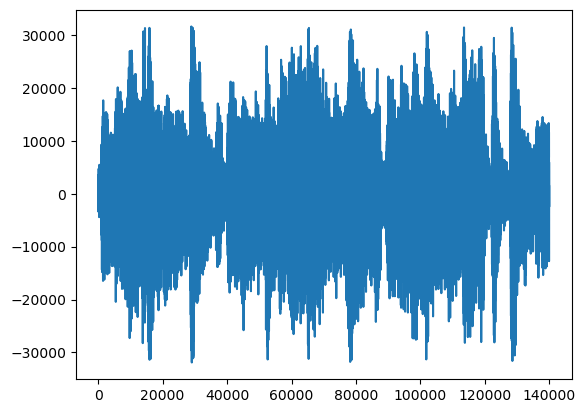

In [140]:
plt.plot(music)

In [141]:
ext_music = np.concatenate((music, np.zeros(len(Phi(PhiS(music))) - len(music))))

In [142]:
clipped_music = np.clip(ext_music, -20000, 20000)

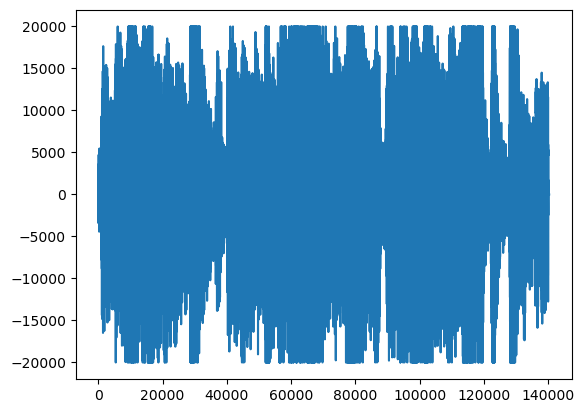

In [143]:
plt.plot(clipped_music)

In [145]:
music_f, music_t, music_z = signal.stft(music, fs=sr, nperseg=1024, noverlap=512)

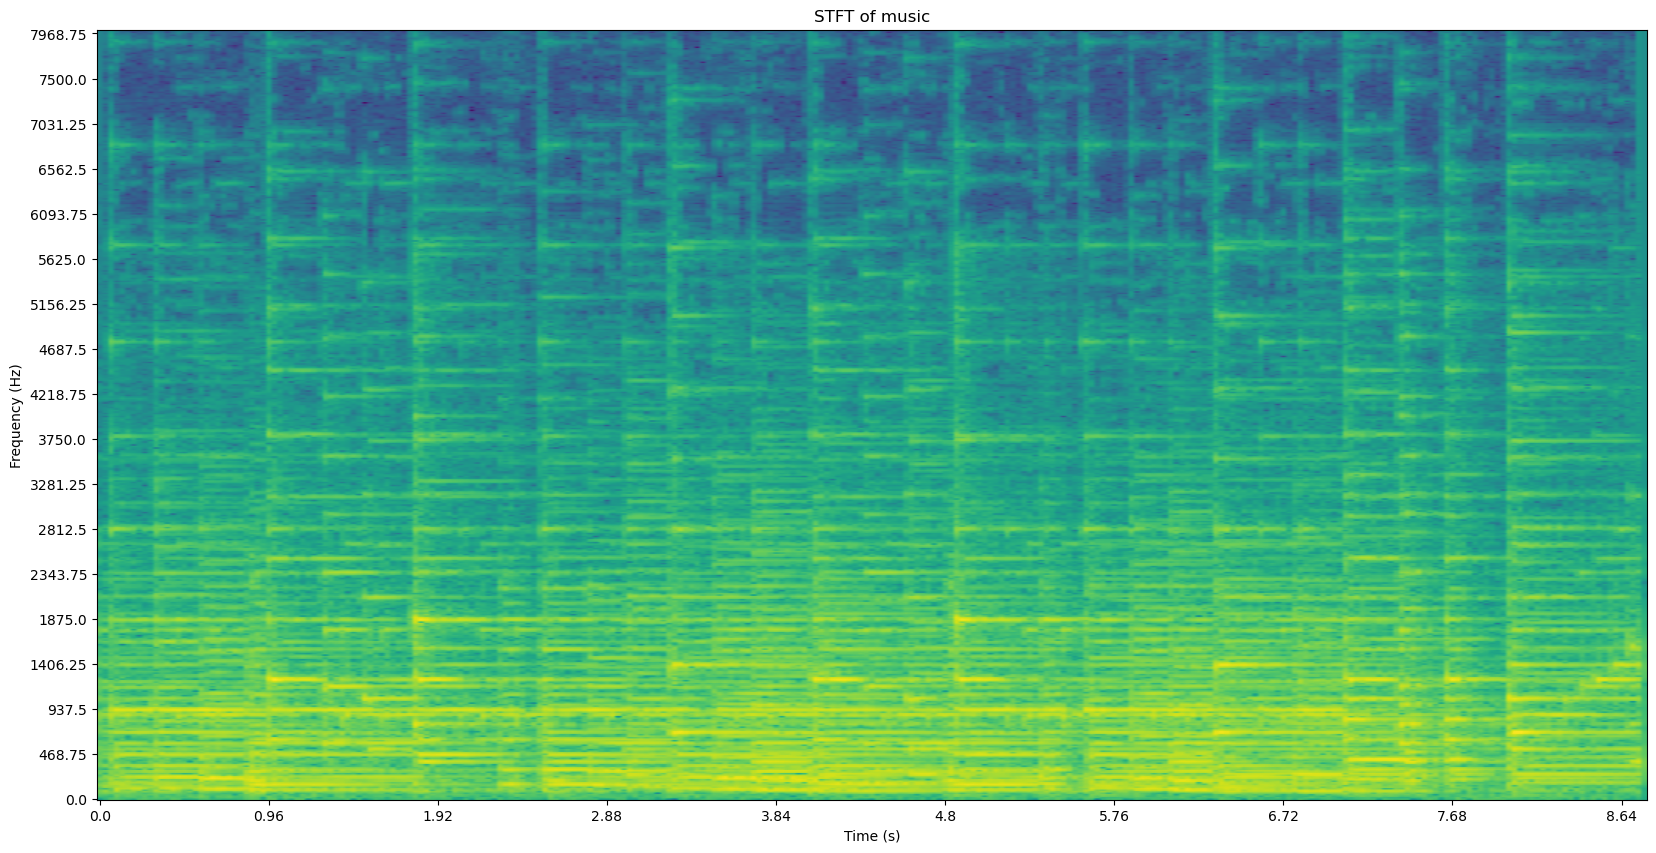

In [146]:
plot_stft(music_f, music_t, np.log(np.abs(music_z)), title='STFT of music')

In [151]:
bad_idx = np.where(np.abs(clipped_music) == 20000 )[0]

In [152]:
good_idx = np.where(np.abs(clipped_music) != 20000 )[0]

In [153]:
M_c = csr_matrix((np.ones(len(bad_idx)), (np.arange(len(bad_idx)), bad_idx)), shape=(len(bad_idx), len(ext_music)))

In [154]:
M_r = csr_matrix((np.ones(len(good_idx)), (np.arange(len(good_idx)), good_idx)), shape=(len(good_idx), len(ext_music)))

In [155]:
y_r = ext_music[good_idx]

In [159]:
theta_clip = clipped_music[bad_idx]

In [204]:
alpha = PhiS(clipped_music)
z = alpha.copy()
alpha_old = alpha.copy()
delta = 1
gamma = 0.9
lamb_start, lamb_end = 1, 0.0001
niter = 1000
lambda_list = np.logspace(lamb_start, lamb_end, niter)

for i, lamda in enumerate(lambda_list):
    g_1 = -PhiS(M_r.T.asformat('csr')@(y_r-M_r@(Phi(z))))
    # g_2 = -PhiS(M_c.T.asformat('csr')@np.maximum(theta_clip-M_c@(Phi(z)), 0))
    g_2 = -PhiS(M_c.T.asformat('csr')@np.where(np.abs(M_c@(Phi(z))) > np.abs(theta_clip), 0, (theta_clip-M_c@(Phi(z)))))

    alpha = soft_thresholding(z - 1/delta * (g_1 + g_2), lamda/delta)
    z = alpha + gamma*(alpha-alpha_old)

    alpha_old = alpha.copy()

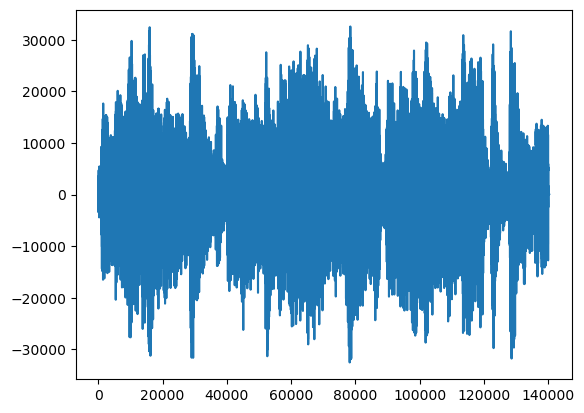

In [205]:
plt.plot(Phi(alpha))

In [206]:
declipped = Phi(alpha)

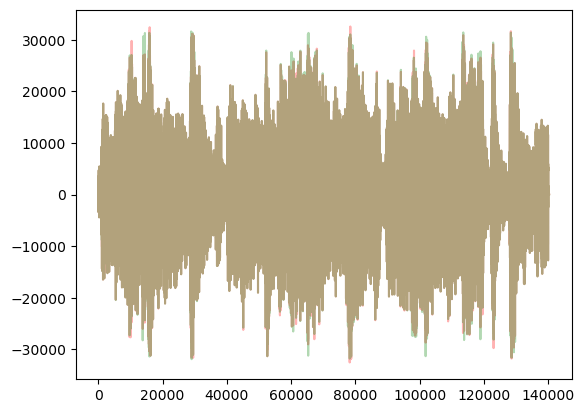

In [209]:
plt.plot(declipped, c='red', alpha=0.3)
plt.plot(ext_music, c='green', alpha=0.3)

In [210]:
from sklearn.metrics import mean_squared_error

In [212]:
mean_squared_error(ext_music, clipped_music, squared=False)

480.6436955103189

In [213]:
mean_squared_error(ext_music, declipped, squared=False)

92.76267436364732